In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

### Importando dados e separando pelo ano ex: 2006 e 2010

In [2]:
#Separando os dados - Como sugerido 2006 treino e 2010 validação
train = pd.read_csv("./xaa.csv")
# Dados de 2010
test = pd.read_csv("./xab.csv")

In [3]:
train.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


In [4]:
all_data = pd.concat((train.loc[:,'uf':'ocupacao'],
                      test.loc[:,'uf':'ocupacao']))

### Pré processamento dos dados

#### 1. Substituindo NaN's pela média.
#### 2. Criando variáveis númericas a partir das variáveis categóricas
#### 3. Normalizando features utilizando log

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f880b589d10>,
      dtype=object)

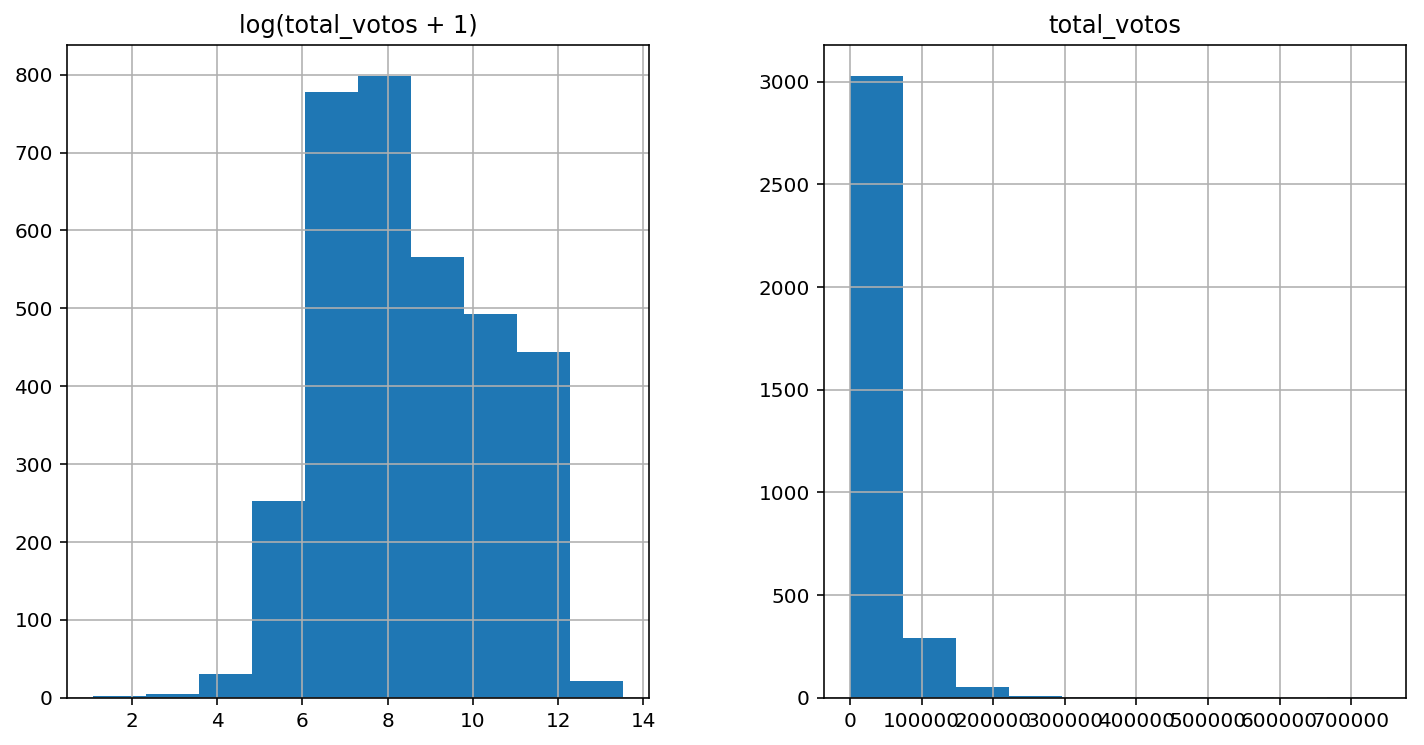

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

total_votos_2006 = pd.DataFrame({"total_votos":train["votos"], "log(total_votos + 1)":np.log1p(train["votos"])})

total_votos_2006.hist()

In [6]:
# log transform the target:
train["votos"] = np.log1p(train["votos"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)

In [8]:
all_data = all_data.fillna(all_data.mean())

In [9]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]

In [10]:
X_test = all_data[train.shape[0]:]

In [11]:
y = train.votos

### Modelos

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [13]:
model_ridge = Ridge()


In [14]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

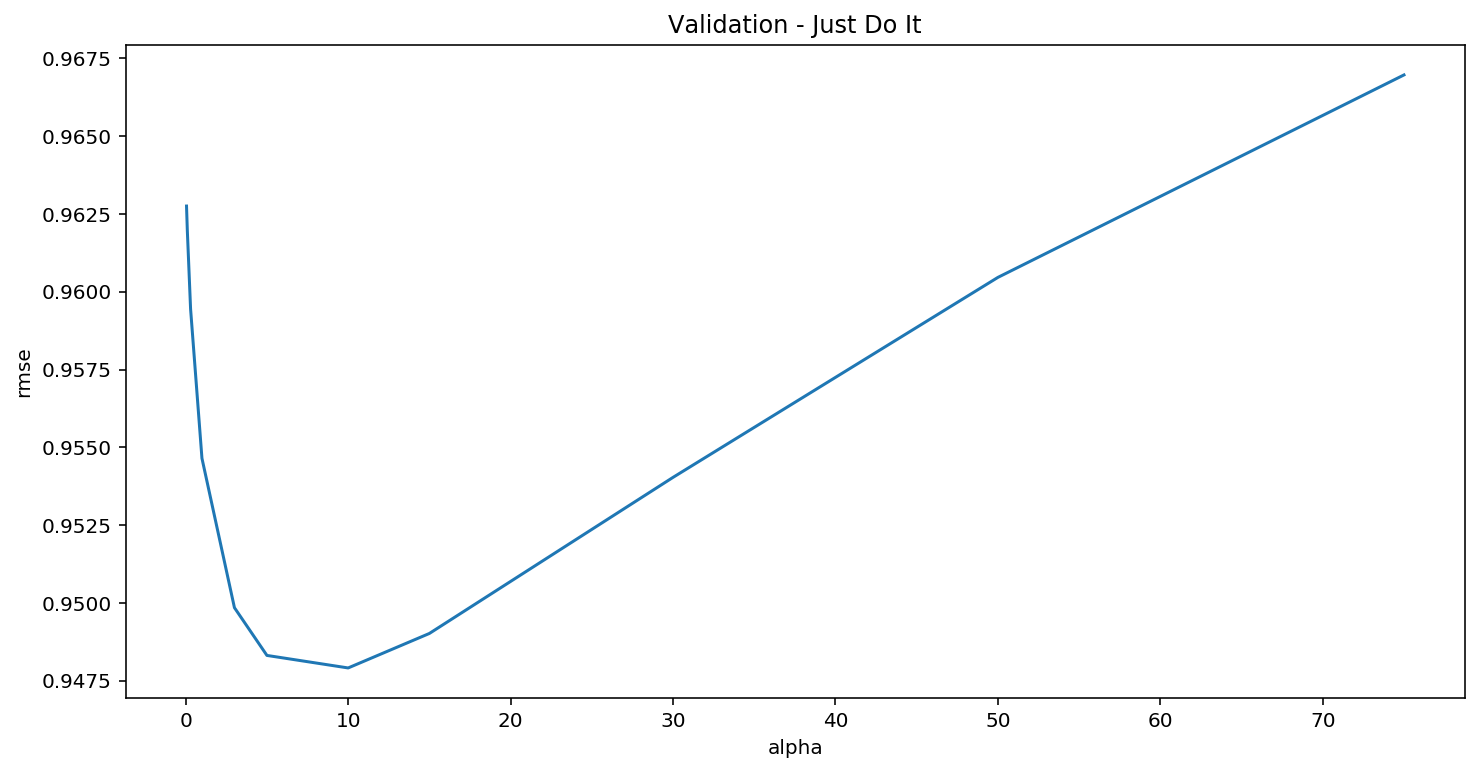

In [15]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [16]:
cv_ridge.min()

0.9479115249847105

In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

In [ ]:
rmse_cv(model_lasso).mean()

/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/cor07/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [ ]:
import xgboost as xgb


In [ ]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()


In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [ ]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"id":test.nome, "Votos":preds, "ano":test.ano})
solution.to_csv("ridge_sol.csv", index = False)

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split